In [12]:
import pickle
import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel

from dltools.cov.markup import compute

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars


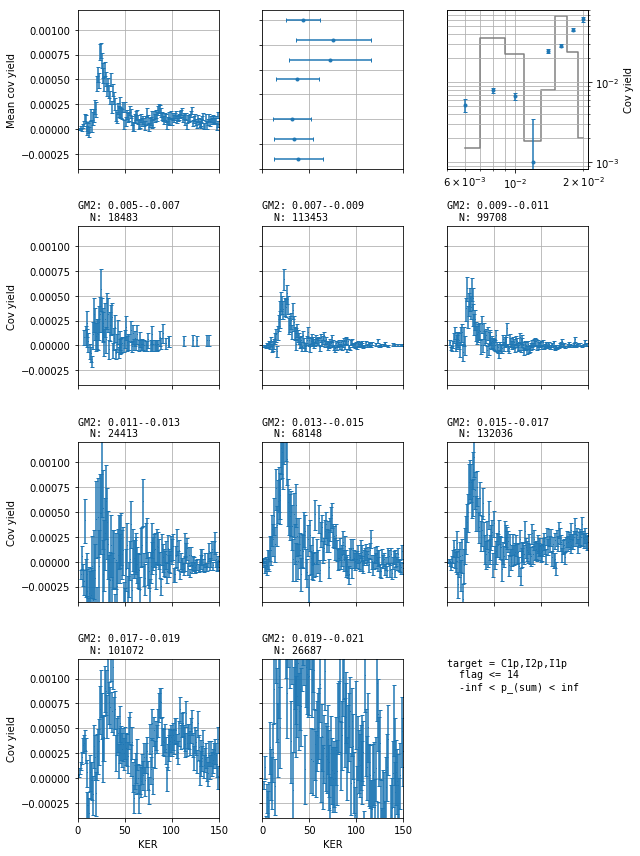

In [2]:
from textwrap import dedent
import os
import pickle
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


step = 0.002
edges = np.arange(0.005, 0.021, step)
xkey, ykey = "ke", "sumke"

filename = ("Data/Cov ang dist and KER; "
            "target=C1p,I2p,I1p "
            "& p=any "
            "& gm2={:.3f}--{:.3f}.pickle").format
note = dedent("""\
    target = C1p,I2p,I1p
      flag <= 14
      -inf < p_(sum) < inf\
""")


def gen():
    for i, fr in enumerate(edges):
        to = fr + step
        fn = filename(fr, to)
        if not os.path.exists(fn):
            continue

        with open(fn, "rb") as fp:
            yield {"i": i,
                   "d": pickle.load(fp),
                   "fr": fr,
                   "to": to}


plt.figure(figsize=(9, 12))
rows = list(gen())
plt.subplot(4, 3, 1)
plt.xlabel("KER")
plt.ylabel("Mean cov yield")
n = sum(r["d"]["N"] for r in rows)
d = {
    "Cov[X,Y,Z]": sum(r["d"]["N"] * r["d"]["Cov[X,Y,Z]"] for r in rows) / n,
    "Err[Cov[X,Y,Z]]": sum((r["d"]["N"] * r["d"]["Err[Cov[X,Y,Z]]"]) ** 2 for r in rows) ** 0.5 / n,
    "Sum[XYZ]": sum(r["d"]["Sum[XYZ]"] for r in rows),
}
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
where = 1 < d["Sum[XYZ]"][ykey]
plt.errorbar(
    d["Cov[X,Y,Z]"][xkey][where] + dx / 2,
    d["Cov[X,Y,Z]"][ykey][where],
    d["Err[Cov[X,Y,Z]]"][ykey][where],
    fmt=" ",
    capsize=2,
)
plt.grid(True)
plt.xlim(0, 150)
plt.ylim(-0.0004, 0.0012)
plt.gca().label_outer()


def gen():
    for r in rows:
        n = r["d"]["N"]
        dx = r["d"]["Cov[X,Y,Z]"][xkey][1] - r["d"]["Cov[X,Y,Z]"][xkey][0]
        where = 0 < r["d"]["Sum[XYZ]"][ykey]
        if where.sum() == 0:
            continue

        ave = np.average(
            r["d"]["Cov[X,Y,Z]"][xkey][where] + dx / 2,
            weights=r["d"]["Cov[X,Y,Z]"][ykey][where],
        )
        std = np.average(
            (r["d"]["Cov[X,Y,Z]"][xkey][where] + dx / 2 - ave) ** 2,
            weights=r["d"]["Cov[X,Y,Z]"][ykey][where],
        ) ** 0.5
        if not np.isfinite(std):
            continue
        yield {"x": ave, "xerr": std, "y": (r["fr"] + r["to"]) / 2}


plt.subplot(4, 3, 2)
plt.xlabel("KER")
plt.ylabel("GM2")
df = pd.DataFrame(list(gen()))
plt.errorbar(
    df["x"], df["y"],
    xerr=df["xerr"],
    fmt=".",
    capsize=2,
)
plt.xlim(0, 150)
plt.ylim(0.005, 0.021)
plt.grid(True)
plt.gca().label_outer()


def gen():
    for r in rows:
        y = r["d"]["Cov[X,Y,Z]"][ykey].sum().values
        yerr = ((r["d"]["Err[Cov[X,Y,Z]]"][ykey] ** 2).sum() ** 0.5).values
        if y < 0:
            continue
        yield {"x": (r["fr"] + r["to"]) / 2,
               "n": r["d"]["N"],
               "y": y,
               "yerr": yerr}


plt.subplot(4, 3, 3)
df = pd.DataFrame(list(gen()))
plt.step(
    df["x"], df["n"],
    where="mid",
    color="gray",
)
plt.ylim(0, None)
plt.minorticks_on()
plt.grid(True, which="both")
plt.yticks([], [])

plt.twinx()
plt.ylabel("Cov yield")
plt.errorbar(
    df["x"], df["y"], df["yerr"],
    fmt=".",
    capsize=2,
)
plt.xlim(0.005, 0.021)
plt.minorticks_on()
plt.grid(True, which="both")
plt.xscale("log")
plt.yscale("log")


for r in rows:
    n = r["d"]["N"]
    dx = r["d"]["Cov[X,Y,Z]"][xkey][1] - r["d"]["Cov[X,Y,Z]"][xkey][0]
    where = r["d"]["Sum[XYZ]"][ykey] != 0

    plt.subplot(4, 3, r["i"] + 4)
    plt.title(f"GM2: {r['fr']:.3f}--{r['to']:.3f}\n"
              f"  N: {n}",
              fontdict={"family": "monospace", "size": "medium"},
              loc="left")
    plt.xlabel("KER")
    plt.ylabel("Cov yield")
    plt.errorbar(
        r["d"]["Cov[X,Y,Z]"][xkey][where] + dx / 2,
        r["d"]["Cov[X,Y,Z]"][ykey][where],
        r["d"]["Err[Cov[X,Y,Z]]"][ykey][where],
        fmt=",",
        capsize=2,
    )
    plt.grid(True)
    plt.xlim(0, 150)
    plt.ylim(-0.0004, 0.0012)
    plt.gca().label_outer()
plt.subplot(4, 3, 12)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

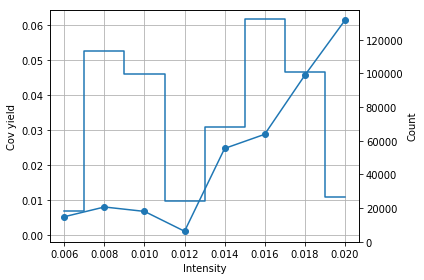

In [3]:
step = 0.002
edges = np.arange(0.005, 0.021, step)
filename = ("Data/Cov ang dist and KER; "
            "target=C1p,I2p,I1p "
            "& p=any "
            "& gm2={:.3f}--{:.3f}.pickle").format


def count():
    for i, fr in enumerate(edges):
        to = fr + step
        fn = filename(fr, to)
        if not os.path.exists(fn):
            continue

        with open(fn, "rb") as fp:
            d = pickle.load(fp)

        key = "sumke"
        yield {"fr": fr,
               "n": d["N"],
               "cov": d["Cov[X,Y,Z]"][key].sum().values}


df = pd.DataFrame(list(count()))

plt.figure()
plt.xlabel("Intensity")
plt.ylabel("Cov yield")
plt.plot(df["fr"] + step / 2, df["cov"], "-o")
plt.grid(True)
v, _ = plt.ylim()
plt.ylim(min(v, 0), None)

plt.twinx()
plt.ylabel("Count")
plt.step(df["fr"] + step / 2, df["n"], where="mid")
plt.ylim(0, None)
plt.tight_layout()
plt.show()

In [4]:
note = textwrap.dedent("""\
    target = C1p,I2p,I1p
      flag <= 14
      -inf < p_(sum) < inf\
""")

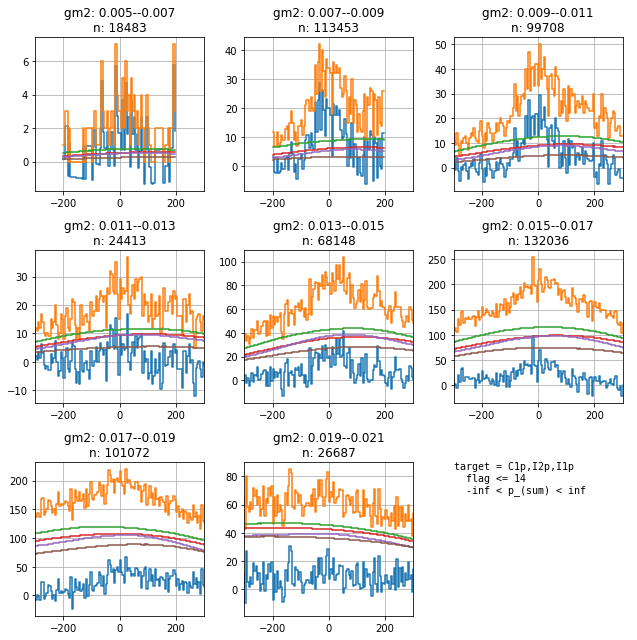

In [5]:
x, y = "p", "sumpz"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.xlim(-300, 300)
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

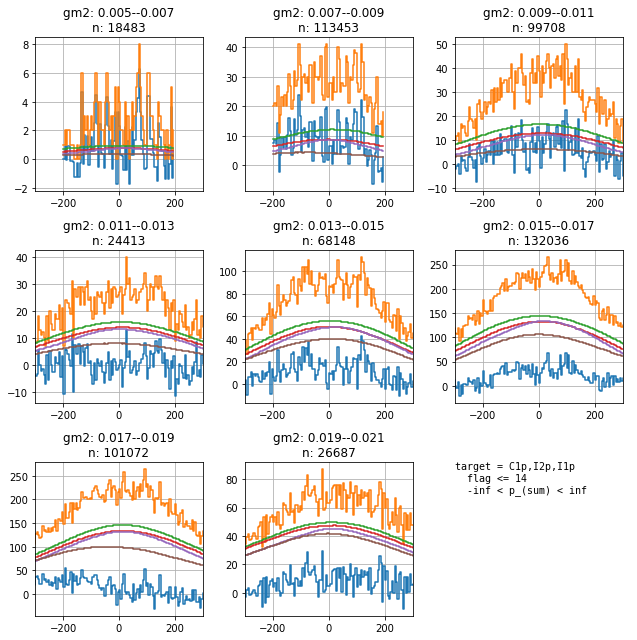

In [6]:
x, y = "p", "sumpx"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.xlim(-300, 300)
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

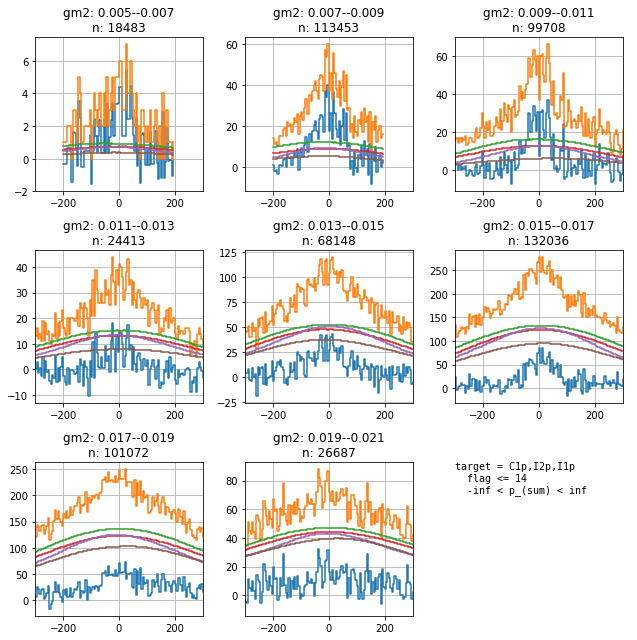

In [7]:
x, y = "p", "sumpy"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.xlim(-300, 300)
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

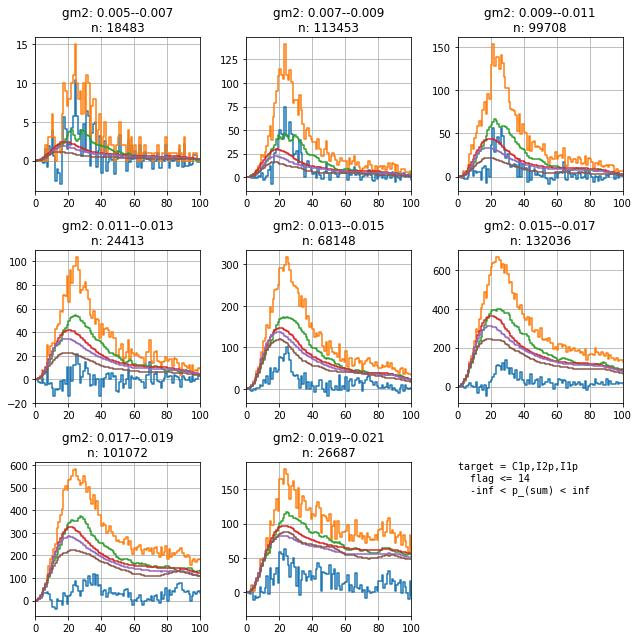

In [11]:
x, y = "ke", "sumke"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.grid(True)
    plt.xlim(0, 100)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

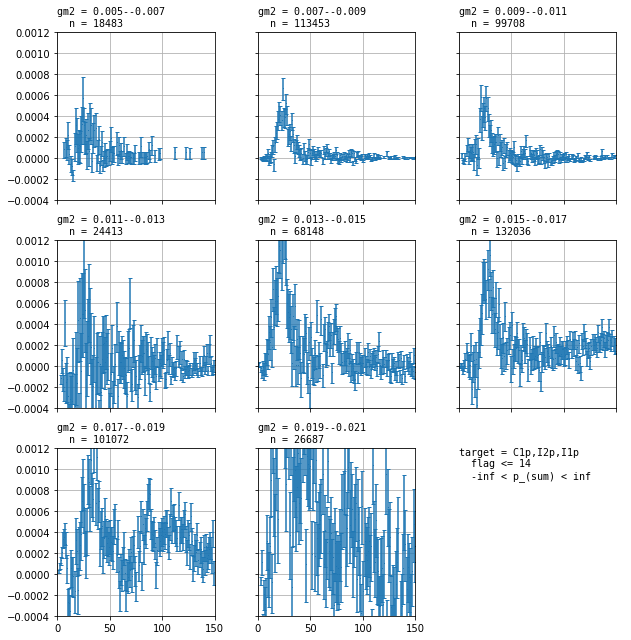

In [9]:
x, y = "ke", "sumke"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]
    dx = d["Cov[X,Y,Z]"][x][1] - d["Cov[X,Y,Z]"][x][0]
    where = d["Sum[XYZ]"][y] != 0

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2 = {fr:.3f}--{to:.3f}\n"
              f"  n = {n}",
              fontdict={"family": "monospace", "size": "medium"},
              loc="left")
    plt.errorbar(
        d["Cov[X,Y,Z]"][x][where] + dx / 2,
        d["Cov[X,Y,Z]"][y][where],
        d["Sum[XYZ]"][y][where] ** 0.5 / n,
        fmt=",",
        capsize=2,
    )
    plt.grid(True)
    plt.xlim(0, 150)
    plt.ylim(-0.0004, 0.0012)
    plt.gca().label_outer()
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

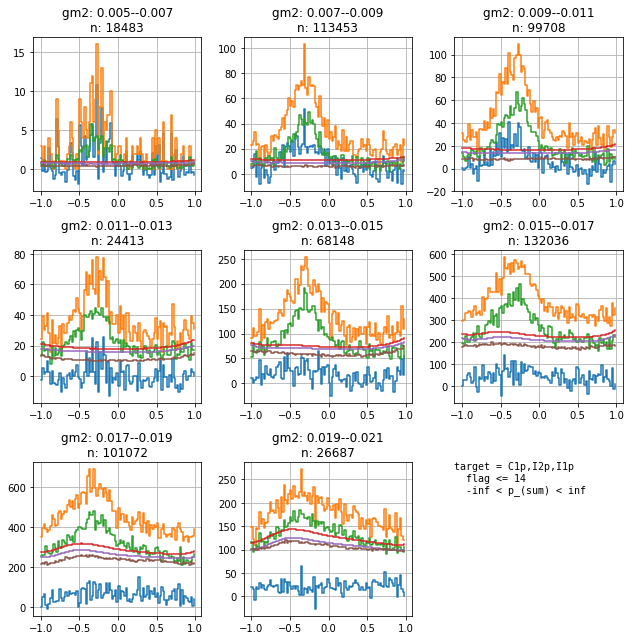

In [10]:
x, y = "cosang", "h0h1angle"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

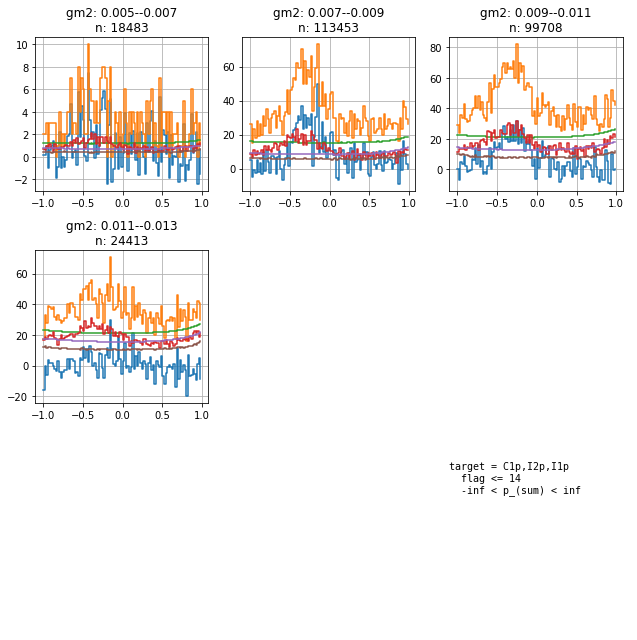

In [20]:
x, y = "cosang", "h0h2angle"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

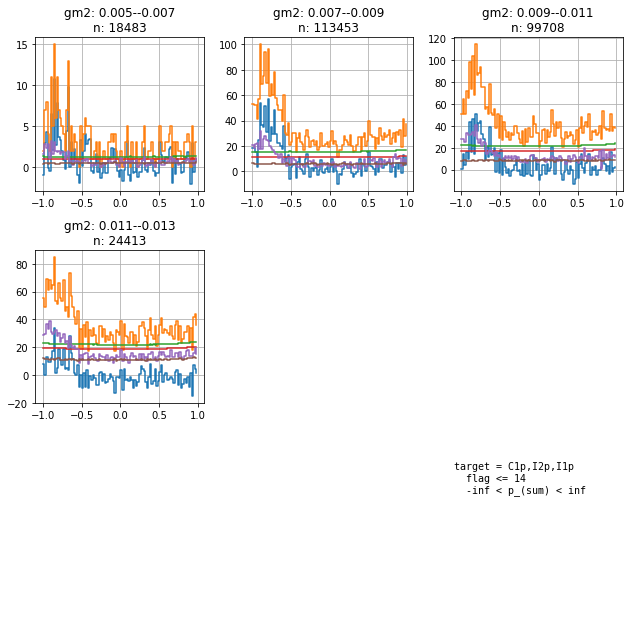

In [21]:
x, y = "cosang", "h1h2angle"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Cov[X,Y,Z]"])
    plt.step(
        arr[x], arr[y] * n,
        label="Cov[X,Y,Z] * N",
        where="post",
    )
    arr = compute(d["Sum[XYZ]"])
    plt.step(
        arr[x], arr[y],
        label="Sum[XYZ]",
        where="post",
    )
    arr = compute(d["Sum[XY]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XY]Sum[Z] / N",
        where="post",
    )
    arr = compute(d["Sum[XZ]Sum[Y]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[XZ]Sum[Y] / N",
        where="post",
    )
    arr = compute(d["Sum[YZ]Sum[X]"])
    plt.step(
        arr[x], arr[y] / n,
        label="Sum[YZ]Sum[X] / N",
        where="post",
    )
    arr = compute(d["Sum[X]Sum[Y]Sum[Z]"])
    plt.step(
        arr[x], arr[y] / n ** 2,
        label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
        where="post",
    )
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

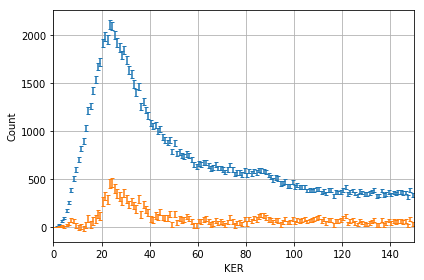

In [40]:
def load():
    for i, fr in enumerate(edges):
        to = fr + step
        fn = filename(fr, to)
        if not os.path.exists(fn):
            continue

        with open(fn, "rb") as fp:
            yield pickle.load(fp)


li = list(load())
n = sum(d["N"] for d in li)
d = {
    "Cov[X,Y,Z]": sum(d["N"] * d["Cov[X,Y,Z]"] for d in li) / n,
    "Err[Cov[X,Y,Z]]": sum((d["N"] * d["Err[Cov[X,Y,Z]]"]) ** 2 for d in li) ** 0.5 / n,
    "Sum[XYZ]": sum(d["Sum[XYZ]"] for d in li),
}
xkey, ykey = "ke", "sumke"
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
x = d["Cov[X,Y,Z]"][xkey] + dx / 2
where = 0 < d["Sum[XYZ]"][ykey]

plt.figure()
plt.xlabel("KER")
plt.ylabel("Count")
plt.errorbar(
    x[where],
    d["Sum[XYZ]"][ykey][where],
    d["Sum[XYZ]"][ykey][where] ** 0.5,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.errorbar(
    x[where],
    d["Cov[X,Y,Z]"][ykey][where] * n,
    d["Err[Cov[X,Y,Z]]"][ykey][where] * n,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.grid(True)
plt.xlim(0, 150)
plt.tight_layout()
plt.show()

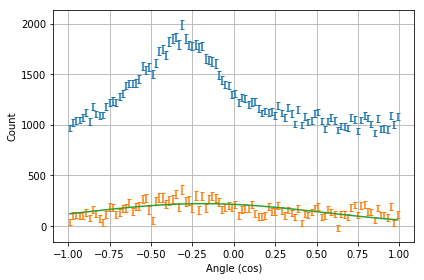

In [43]:
def load():
    for i, fr in enumerate(edges):
        to = fr + step
        fn = filename(fr, to)
        if not os.path.exists(fn):
            continue

        with open(fn, "rb") as fp:
            yield pickle.load(fp)


li = list(load())
n = sum(d["N"] for d in li)
d = {
    "Cov[X,Y,Z]": sum(d["N"] * d["Cov[X,Y,Z]"] for d in li) / n,
    "Err[Cov[X,Y,Z]]": sum((d["N"] * d["Err[Cov[X,Y,Z]]"]) ** 2 for d in li) ** 0.5 / n,
    "Sum[XYZ]": sum(d["Sum[XYZ]"] for d in li),
}
xkey, ykey = "cosang", "h0h1angle"
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
x = d["Cov[X,Y,Z]"][xkey] + dx / 2
where = 0 < d["Sum[XYZ]"][ykey]

plt.figure()
plt.xlabel("Angle (cos)")
plt.ylabel("Count")
plt.errorbar(
    x[where],
    d["Sum[XYZ]"][ykey][where],
    d["Sum[XYZ]"][ykey][where] ** 0.5,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.errorbar(
    x[where],
    d["Cov[X,Y,Z]"][ykey][where] * n,
    d["Err[Cov[X,Y,Z]]"][ykey][where] * n,
    fmt=" ",
    capsize=2,
    label="Cov",
)
model = GaussianModel()
fitted = model.fit(
    d["Cov[X,Y,Z]"][ykey][where],
    weights=d["Err[Cov[X,Y,Z]]"][ykey][where],
    x=x[where])
plt.plot(x, fitted.eval(x=x) * n)
plt.grid(True)
plt.tight_layout()
plt.show()

fitted

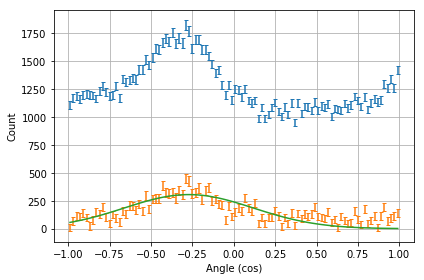

In [44]:
def load():
    for i, fr in enumerate(edges):
        to = fr + step
        fn = filename(fr, to)
        if not os.path.exists(fn):
            continue

        with open(fn, "rb") as fp:
            yield pickle.load(fp)


li = list(load())
n = sum(d["N"] for d in li)
d = {
    "Cov[X,Y,Z]": sum(d["N"] * d["Cov[X,Y,Z]"] for d in li) / n,
    "Err[Cov[X,Y,Z]]": sum((d["N"] * d["Err[Cov[X,Y,Z]]"]) ** 2 for d in li) ** 0.5 / n,
    "Sum[XYZ]": sum(d["Sum[XYZ]"] for d in li),
}
xkey, ykey = "cosang", "h0h2angle"
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
x = d["Cov[X,Y,Z]"][xkey] + dx / 2
where = 0 < d["Sum[XYZ]"][ykey]

plt.figure()
plt.xlabel("Angle (cos)")
plt.ylabel("Count")
plt.errorbar(
    x[where],
    d["Sum[XYZ]"][ykey][where],
    d["Sum[XYZ]"][ykey][where] ** 0.5,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.errorbar(
    x[where],
    d["Cov[X,Y,Z]"][ykey][where] * n,
    d["Err[Cov[X,Y,Z]]"][ykey][where] * n,
    fmt=" ",
    capsize=2,
    label="Cov",
)
model = GaussianModel()
fitted = model.fit(
    d["Cov[X,Y,Z]"][ykey][where],
    weights=d["Err[Cov[X,Y,Z]]"][ykey][where],
    x=x[where])
plt.plot(x, fitted.eval(x=x) * n)
plt.grid(True)
plt.tight_layout()
plt.show()

fitted

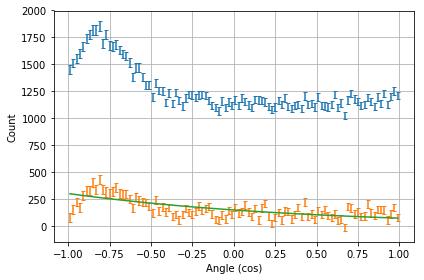

In [45]:
def load():
    for i, fr in enumerate(edges):
        to = fr + step
        fn = filename(fr, to)
        if not os.path.exists(fn):
            continue

        with open(fn, "rb") as fp:
            yield pickle.load(fp)


li = list(load())
n = sum(d["N"] for d in li)
d = {
    "Cov[X,Y,Z]": sum(d["N"] * d["Cov[X,Y,Z]"] for d in li) / n,
    "Err[Cov[X,Y,Z]]": sum((d["N"] * d["Err[Cov[X,Y,Z]]"]) ** 2 for d in li) ** 0.5 / n,
    "Sum[XYZ]": sum(d["Sum[XYZ]"] for d in li),
}
xkey, ykey = "cosang", "h1h2angle"
dx = d["Cov[X,Y,Z]"][xkey][1] - d["Cov[X,Y,Z]"][xkey][0]
x = d["Cov[X,Y,Z]"][xkey] + dx / 2
where = 0 < d["Sum[XYZ]"][ykey]

plt.figure()
plt.xlabel("Angle (cos)")
plt.ylabel("Count")
plt.errorbar(
    x[where],
    d["Sum[XYZ]"][ykey][where],
    d["Sum[XYZ]"][ykey][where] ** 0.5,
    fmt=" ",
    capsize=2,
    label="Cov",
)
plt.errorbar(
    x[where],
    d["Cov[X,Y,Z]"][ykey][where] * n,
    d["Err[Cov[X,Y,Z]]"][ykey][where] * n,
    fmt=" ",
    capsize=2,
    label="Cov",
)
model = GaussianModel()
model.
fitted = model.fit(
    d["Cov[X,Y,Z]"][ykey][where],
    weights=d["Err[Cov[X,Y,Z]]"][ykey][where],
    x=x[where])
plt.plot(x, fitted.eval(x=x) * n)
plt.grid(True)
plt.tight_layout()
plt.show()

fitted

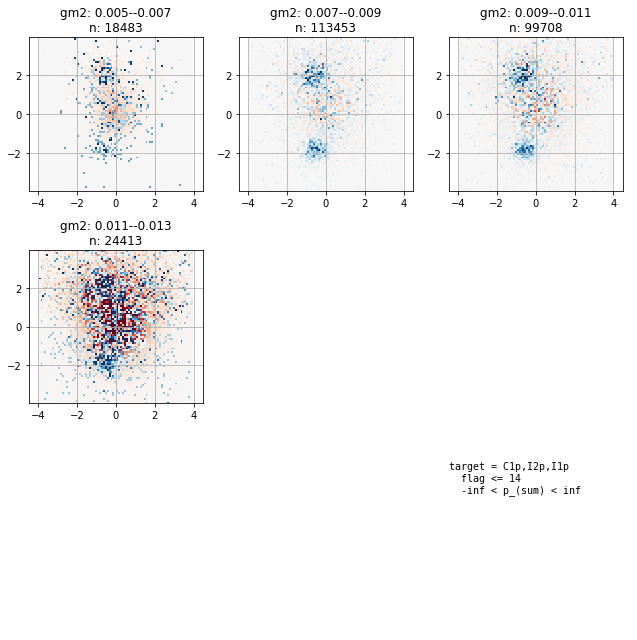

In [31]:
x, y, c0, c1 = "normp0", "normp1", "h1normpxy", "h2normpxy"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
#     arr = compute(d["Sum[XYZ]"])
    arr = compute(d["Cov[X,Y,Z]"])
    dx = arr[x][1] - arr[x][0]
    dy = arr[y][1] - arr[y][0]
    plt.pcolormesh(
        arr[x] + dx / 2,
        arr[y] + dy / 2,
        (arr[c0] + arr[c1]).T,
        cmap="RdBu",
        label="Cov[X,Y,Z]",
    )
    plt.clim(-0.0001, 0.0001)
    plt.axis("equal")
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()

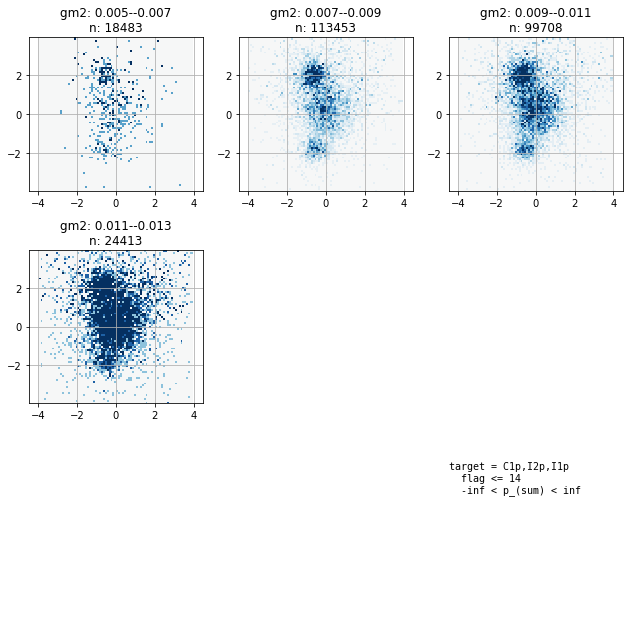

In [32]:
x, y, c0, c1 = "normp0", "normp1", "h1normpxy", "h2normpxy"

plt.figure(figsize=(9, 9))
for i, fr in enumerate(edges):
    to = fr + step
    fn = filename(fr, to)
    if not os.path.exists(fn):
        continue

    with open(fn, "rb") as fp:
        d = pickle.load(fp)
    n = d["N"]

    plt.subplot(3, 3, i + 1)
    plt.title(f"gm2: {fr:.3f}--{to:.3f}\nn: {n}")
    arr = compute(d["Sum[XYZ]"])
    dx = arr[x][1] - arr[x][0]
    dy = arr[y][1] - arr[y][0]
    plt.pcolormesh(
        arr[x] + dx / 2,
        arr[y] + dy / 2,
        (arr[c0] + arr[c1]).T / n,
        cmap="RdBu",
        label="Sum[XYZ] / N",
    )
    plt.clim(-0.0001, 0.0001)
    plt.axis("equal")
    plt.grid(True)
plt.subplot(339)
plt.text(0, 1, note,
         fontdict={"family": "monospace"},
         verticalalignment="top")
plt.axis("off")
plt.tight_layout()
plt.show()